In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
dfParticipants = pd.read_csv("R-SED_data/participants.csv", delimiter=",", index_col=0)

In [3]:
dfJudgements = pd.read_csv("R-SED_data/triplet_judgements.csv", delimiter=",", index_col=0)

In [4]:
dfTriplets = pd.read_csv("R-SED_data/triplets.csv", delimiter=",", index_col=0)

In [5]:
dfAll = dfParticipants.join(dfJudgements.reset_index().set_index("user_id"), how="inner")
dfAll = dfAll.reset_index().set_index("triplet_id").join(dfTriplets, how="inner").reset_index().set_index("judgement_id")
dfAll.head(3)

,triplet_id,user_id,age_group,education,ml_expert,choice,simplified_choice,option_one_path,option_two_path,time_spent,handheld,window_width,window_height,user_agent,model,target_path,candidate1_path,candidate2_path,candidate1_bin,candidate2_bin,W2VVExtractor_cosdist_query_candidate1,W2VVExtractor_cosdist_query_candidate2,W2VVExtractor_cosdist_candidates,W2VVExtractor_eucldist_query_candidate1,W2VVExtractor_eucldist_query_candidate2,W2VVExtractor_eucldist_candidates,CIELABPositionalExctractor_regions_2x2_cosdist_query_candidate1,CIELABPositionalExctractor_regions_2x2_cosdist_query_candidate2,CIELABPositionalExctractor_regions_2x2_cosdist_candidates,CIELABPositionalExctractor_regions_2x2_eucldist_query_candidate1,CIELABPositionalExctractor_regions_2x2_eucldist_query_candidate2,CIELABPositionalExctractor_regions_2x2_eucldist_candidates,VLADExctractor__cosdist_query_candidate1,VLADExctractor__cosdist_query_candidate2,VLADExctractor__cosdist_candidates,VLADExctractor__eucldist_query_candidate1,VLADExctractor__eucldist_query_candidate2,VLADExctractor__eucldist_candidates,RGBHistogramExtractor_256_cosdist_query_candidate1,RGBHistogramExtractor_256_cosdist_query_candidate2,RGBHistogramExtractor_256_cosdist_candidates,RGBHistogramExtractor_256_eucldist_query_candidate1,RGBHistogramExtractor_256_eucldist_query_candidate2,RGBHistogramExtractor_256_eucldist_candidates,ConvNeXTExtractor_tiny_cosdist_query_candidate1,ConvNeXTExtractor_tiny_cosdist_query_candidate2,ConvNeXTExtractor_tiny_cosdist_candidates,ConvNeXTExtractor_tiny_eucldist_query_candidate1,ConvNeXTExtractor_tiny_eucldist_query_candidate2,ConvNeXTExtractor_tiny_eucldist_candidates,ViTExtractor_base_cosdist_query_candidate1,ViTExtractor_base_cosdist_query_candidate2,ViTExtractor_base_cosdist_candidates,ViTExtractor_base_eucldist_query_candidate1,ViTExtractor_base_eucldist_query_candidate2,ViTExtractor_base_eucldist_candidates,EfficientNetExtractor_0_cosdist_query_candidate1,EfficientNetExtractor_0_cosdist_query_candidate2,EfficientNetExtractor_0_cosdist_candidates,EfficientNetExtractor_0_eucldist_query_candidate1,EfficientNetExtractor_0_eucldist_query_candidate2,EfficientNetExtractor_0_eucldist_candidates,ConvNeXTExtractor_small_cosdist_query_candidate1,ConvNeXTExtractor_small_cosdist_query_candidate2,ConvNeXTExtractor_small_cosdist_candidates,ConvNeXTExtractor_small_eucldist_query_candidate1,ConvNeXTExtractor_small_eucldist_query_candidate2,ConvNeXTExtractor_small_eucldist_candidates,CIELABPositionalExctractor_regions_4x4_cosdist_query_candidate1,CIELABPositionalExctractor_regions_4x4_cosdist_query_candidate2,CIELABPositionalExctractor_regions_4x4_cosdist_candidates,CIELABPositionalExctractor_regions_4x4_eucldist_query_candidate1,CIELABPositionalExctractor_regions_4x4_eucldist_query_candidate2,CIELABPositionalExctractor_regions_4x4_eucldist_candidates,EfficientNetExtractor_4_cosdist_query_candidate1,EfficientNetExtractor_4_cosdist_query_candidate2,EfficientNetExtractor_4_cosdist_candidates,EfficientNetExtractor_4_eucldist_query_candidate1,EfficientNetExtractor_4_eucldist_query_candidate2,EfficientNetExtractor_4_eucldist_candidates,ConvNeXTExtractor_base_cosdist_query_candidate1,ConvNeXTExtractor_base_cosdist_query_candidate2,ConvNeXTExtractor_base_cosdist_candidates,ConvNeXTExtractor_base_eucldist_query_candidate1,ConvNeXTExtractor_base_eucldist_query_candidate2,ConvNeXTExtractor_base_eucldist_candidates,RGBHistogramExtractor_64_cosdist_query_candidate1,RGBHistogramExtractor_64_cosdist_query_candidate2,RGBHistogramExtractor_64_cosdist_candidates,RGBHistogramExtractor_64_eucldist_query_candidate1,RGBHistogramExtractor_64_eucldist_query_candidate2,RGBHistogramExtractor_64_eucldist_candidates,CLIPExtractor_medium_cosdist_query_candidate1,CLIPExtractor_medium_cosdist_query_candidate2,CLIPExtractor_medium_cosdist_candidates,CLIPExtractor_medium_eucldist_query_candidate1,CLIPExtractor_medium_eucldist_query_candidate2,CLIPExtractor_medium_eucldist_candidates,VANExtractor_base_cosdist_

# Divide judgements by the participant's device type
- handheld vs. desktop

## Simplified judgement analysis
- focusing only on whether left or right choice was more similar
- ignoring indifferent judgements as well as magnitude of user's judgement
- analysis is limited to cosine distance

In [6]:
extractors = dfAll.model.unique()
extractors.sort()
dfAll["candidate1DisplayedOnLeft"] = (dfAll["option_one_path"] == dfAll["candidate1_path"])
columnsToDrop = []
for extractor in extractors:
    col1 = extractor+"_cosdist_query_candidate1"
    col2 = extractor+"_cosdist_query_candidate2"
    col1e = extractor+"_eucldist_query_candidate1"
    col2e = extractor+"_eucldist_query_candidate2"
    opt = extractor+"_eucldist_candidates"
    #dealing with the fact that either of candidate1 and candidate2 can be displayed as left/right option
    dfAll[extractor+"_option_left_dist"] = dfAll[col2]
    dfAll[extractor+"_option_right_dist"] = dfAll[col1]
    dfAll.loc[dfAll["candidate1DisplayedOnLeft"],extractor+"_option_left_dist"] = dfAll[col1]
    dfAll.loc[dfAll["candidate1DisplayedOnLeft"],extractor+"_option_right_dist"] = dfAll[col2]
    
    #assessing consistency of the model with human judgement
    right_option_better = ((dfAll[extractor+"_option_left_dist"] > dfAll[extractor+"_option_right_dist"]))
    dfAll["better_for_"+extractor] = right_option_better.astype(int) * 2 - 1
    
    dfAll["same_as_model_"+extractor] = dfAll["simplified_choice"] == dfAll["better_for_"+extractor]
    
    #cleaning the data frame
    columnsToDrop.extend([col1,col2,col1e,col2e,opt])    
dfConsistency = dfAll.drop(columnsToDrop,axis=1)   
dfConsistencyNonUnknown = dfConsistency.loc[dfConsistency.simplified_choice!=0]

In [7]:
dfHandheld = dfConsistencyNonUnknown.loc[dfConsistencyNonUnknown.handheld==True]
dfDesktop = dfConsistencyNonUnknown.loc[dfConsistencyNonUnknown.handheld==False]
dfHandheld.shape, dfDesktop.shape

((3324, 172), (10739, 172))

## Evaluation variant 1: all user judgement decisions count equally

In [8]:
def scoreCounting(df):
    extrNames = []
    scores = []
    for extractor in extractors:
        name = "same_as_model_"+extractor
        extrNames.extend([extractor]*df.shape[0])
        scores.extend(df[name].values.tolist())  
    dfScores = pd.DataFrame({"Extractor":extrNames,"consistent":scores})
    return(dfScores)

In [9]:
dfScoresHandheld = scoreCounting(dfHandheld)
dfScoresDesktop = scoreCounting(dfDesktop)
dfScores = scoreCounting(dfConsistencyNonUnknown)

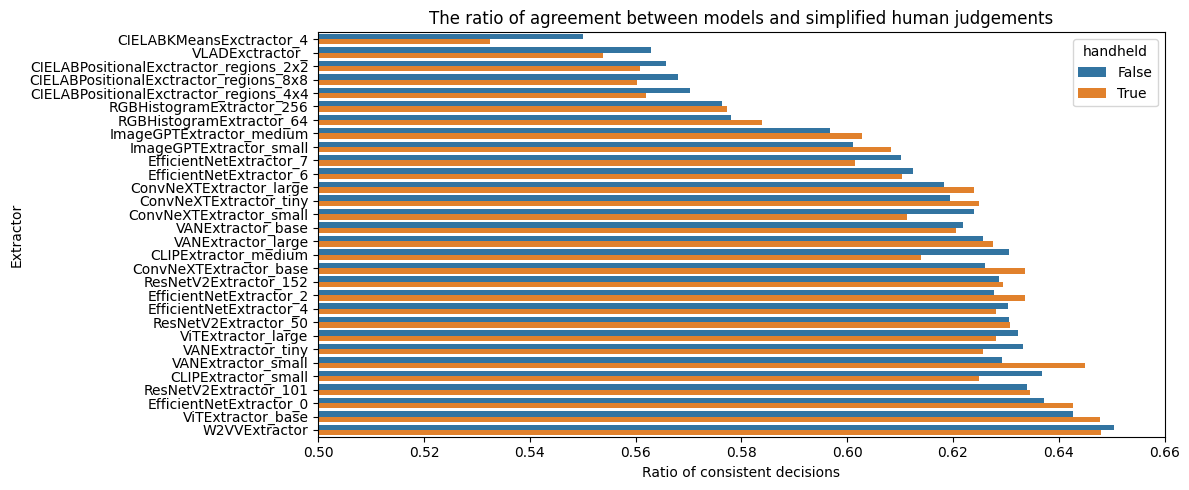

In [10]:
dfScoresHandheld["handheld"] = True
dfScoresDesktop["handheld"] = False
dfScoresBoth = pd.concat([dfScoresHandheld,dfScoresDesktop])
plt.figure(figsize=(15,6))
plt.title("The ratio of agreement between models and simplified human judgements")
sns.barplot(data = dfScoresBoth
            ,x="consistent",y="Extractor"
            , order=dfScores.groupby("Extractor")["consistent"].sum().sort_values().index
            , hue="handheld"
            , errorbar=None)

fig = plt.gcf()
fig.set_size_inches(12, 5)

ax = plt.gca()
ax.set_xlabel("Ratio of consistent decisions")
ax.set_xlim(0.5,0.66)

plt.tight_layout()

In [11]:
dfDiff = (dfScoresHandheld.groupby("Extractor").mean() - dfScoresDesktop.groupby("Extractor").mean()).reset_index()

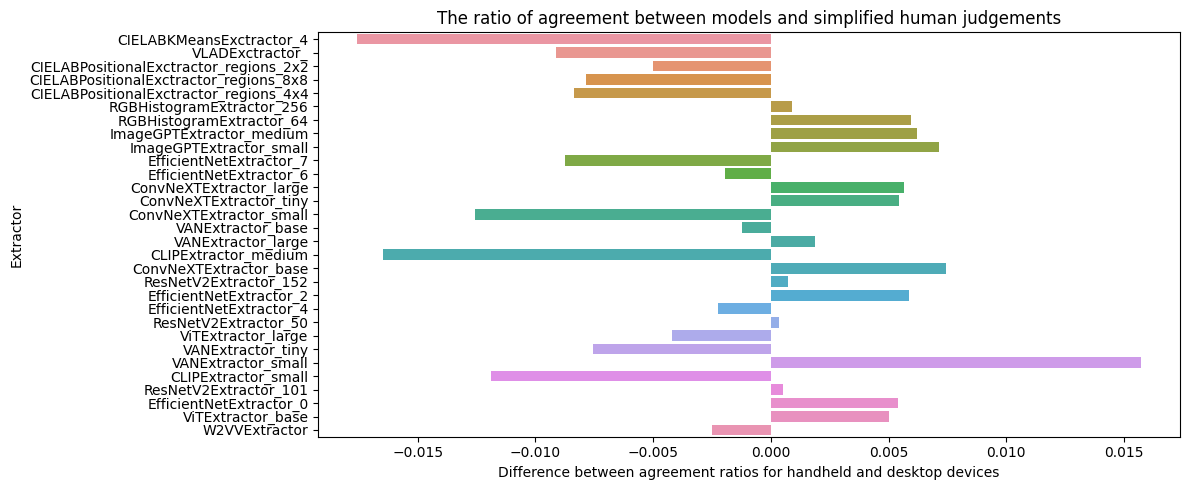

In [12]:
plt.figure(figsize=(15,6))
plt.title("The ratio of agreement between models and simplified human judgements")
sns.barplot(data = dfDiff
            ,x="consistent",y="Extractor"
            , order=dfScores.groupby("Extractor").mean().sort_values("consistent").index)

fig = plt.gcf()
fig.set_size_inches(12, 5)

ax = plt.gca()
ax.set_xlabel("Difference between agreement ratios for handheld and desktop devices")
#ax.set_xlim(0.5,0.66)

plt.tight_layout()
plt.savefig("img/deviceType_agreementDiff.pdf")
plt.show()

Notable points:
- Quite surprisingly, none of the extractors exhibited any substantial differences of treatment